In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import sys

### Input

Setting some constant values for the notebook

In [9]:
manualSeed = 230
datafile = "./S_configs_64x64.dat"
batch_size = 32
start_config = 15000
num_configs = 10240
Ny = 64
Nx = 64
nc = 1
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.000001
beta1 = 0.5
ngpu = 1
N = Ny * Nx
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

### Neural net
#### Generator
We follow the standard DCGAN generator network with one difference in the last layer. After tanh in the last layer, we set all elements larger than 0 to 1, and all elements less than 0 to -1, so the output is the usual Ising spin values. Let's call this procedure stepping because the function resembles a step function :)

In [3]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
class Stepping(nn.Module):
    def __init__(self):
        super(Stepping, self).__init__()
        
    def forward(self, x):
        return (x > 0).type_as(x) * 2 - 1

In [6]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

### Data

Load data and seed

In [8]:
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)

In [10]:
S_snapshots = np.fromfile(datafile, dtype=np.int32)
print("S_snapshots.shape =", S_snapshots.shape)
S_snapshots.shape = -1, 1, Ny, Nx
print("S_snapshots.shape =", S_snapshots.shape)
S_snapshots = S_snapshots[start_config:]
print("S_snapshots.shape =", S_snapshots.shape)
np.random.shuffle(S_snapshots)
S_snapshots_tensor = torch.tensor(S_snapshots, dtype=torch.double)

S_snapshots.shape = (409600000,)
S_snapshots.shape = (100000, 1, 64, 64)
S_snapshots.shape = (85000, 1, 64, 64)


Let's visualize the data

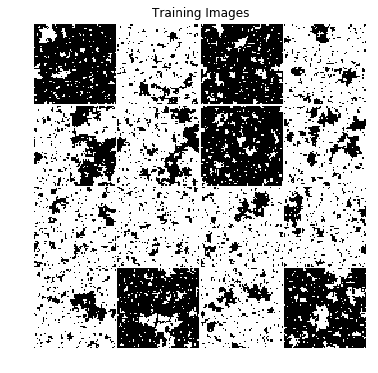

In [11]:
a = torch.tensor(S_snapshots[:16])
b = vutils.make_grid(a, nrow=4, padding=1, normalize=True)
plt.figure(figsize=(6,6))
plt.axis("off")
plt.title("Training Images")
plt.pcolormesh(b[0], cmap='gray_r')
plt.show()

#### Training
Make dataloader

In [12]:
dataloader = torch.utils.data.DataLoader(S_snapshots_tensor[0:num_configs], batch_size=batch_size, shuffle=False)

Initialize generator and discriminator and start training

In [13]:
# Create the generator
netG = Generator(ngpu).to(device)
# GPU
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [14]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [15]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 0.9
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [16]:
def check_gradient(net):
    grad = 0
    for module in net.modules():
        for param in module.parameters():
            try:
                grad += param.grad.abs().sum().item()
            except:
                continue
    return grad

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader):

        ############################
        # (1) Update G network: maximize log(D(G(z)))
        ###########################
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        ## Train with all-fake batch
        # Generate batch of latent vectors
        netG.zero_grad()
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label = torch.full((b_size,), real_label, device=device)   # fake labels are real for generator cost
        # Classify all fake batch with D
        output = netD(fake).view(-1)
        # Calculate G's loss on the all-fake batch
        errG = criterion(output, label)
        # Calculate the gradients for this batch
        errG.backward()
        D_G_z1 = output.mean().item()
        # Update G
        optimizerG.step()
        
        for j in range(1,3):
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise)
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()
            if i % 20 == 0:
                print("G training {}, loss {}, D(G(z)) {}".format(j, errG.item(), D_G_z2))

        ############################
        # (2) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu.float()).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()
        
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z2 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        # Output training stats
        if i % 20 == 0:
            print('\n')
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            print("G gradient: ", check_gradient(netG))
            print("D gradient: ", check_gradient(netD))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
G training 1, loss 1.238724708557129, D(G(z)) 0.34239888191223145
G training 2, loss 1.1022164821624756, D(G(z)) 0.36133915185928345


[0/5][0/320]	Loss_D: 1.6959	Loss_G: 1.1022	D(x): 0.3366	D(G(z)): 0.3114 / 0.3613
G gradient:  120072.01197767258
D gradient:  65933.76660096645
G training 1, loss 0.9533228874206543, D(G(z)) 0.4312041103839874
G training 2, loss 1.0177874565124512, D(G(z)) 0.40598708391189575


[0/5][20/320]	Loss_D: 1.6599	Loss_G: 1.0178	D(x): 0.3941	D(G(z)): 0.4486 / 0.4060
G gradient:  111997.55305659771
D gradient:  66371.08228182793
G training 1, loss 0.8507505655288696, D(G(z)) 0.509000301361084
G training 2, loss 0.7420932054519653, D(G(z)) 0.5140374898910522


[0/5][40/320]	Loss_D: 1.8475	Loss_G: 0.7421	D(x): 0.3916	D(G(z)): 0.5223 / 0.5140
G gradient:  87476.0360519886
D gradient:  74962.55619335175
G training 1, loss 0.8316096663475037, D(G(z)) 0.5027353167533875
G training 2, loss 0.7432429790496826, D(G(z)) 0.5580835342407227


[0/5]

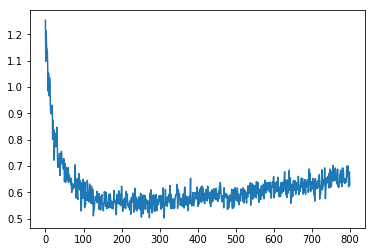

In [16]:
plt.plot(range(len(G_losses)), G_losses)

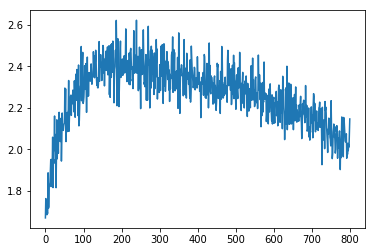

In [17]:
plt.plot(range(len(D_losses)), D_losses)

#### Check gradients

In [ ]:
G_modules_list = list(netG.modules())
D_modules_list = list(netD.modules())

In [ ]:
print(G_modules_list[5], D_modules_list[4])
g_param = list(G_modules_list[5].parameters())
d_param = list(D_modules_list[4].parameters())

In [ ]:
g_param[0].grad

In [ ]:
d_param[0].grad[0,0,0,0]

#### check output

In [18]:
fake = netG(fixed_noise)

In [19]:
output = netD(fake).view(-1)

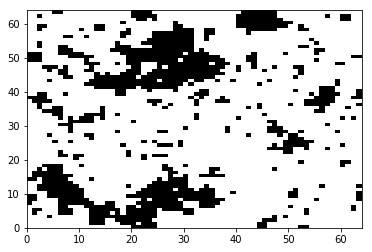

In [21]:
plt.pcolormesh(S_snapshots[1939,0], cmap='binary')
plt.show()

In [22]:
step_f = Stepping()

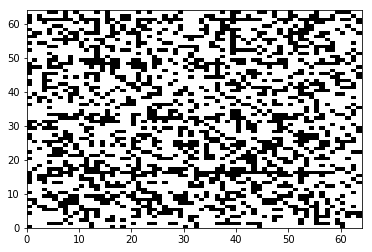

In [23]:
plt.pcolormesh(step_f(fake[34].detach().cpu()[0]), cmap='binary')
plt.show()

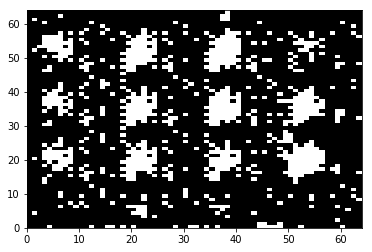

In [54]:
plt.pcolormesh(step_f(fake[42].detach().cpu()[0]), cmap='binary')
plt.show()

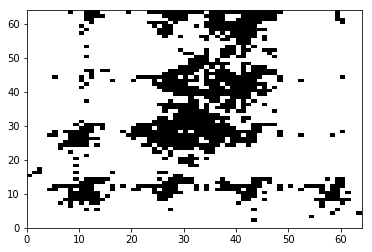

In [55]:
plt.pcolormesh(step_f(fake[43].detach().cpu()[0]), cmap='binary')
plt.show()

In [67]:
step_f(fake[12].detach().cpu()[0])

tensor([[-1., -1., -1.,  ...,  1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ...,  1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

In [ ]:
plt.pcolormesh(data[5][0], cmap='binary')